### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

# from db_queries import get_outputs as go
# from db_queries import get_ids
# from get_draws.api import get_draws
from db_queries import get_population

import altair as alt
from vega_datasets import data

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/19.5_51_locations/results_data

binned_ldl_exposure_time.csv     risk_exposure_time.csv
binned_ldl_exposure_time.hdf     risk_exposure_time.hdf
binned_sbp_exposure_time.csv     sbp_medication_person_time.csv
binned_sbp_exposure_time.hdf     sbp_medication_person_time.hdf
deaths.csv                       state_person_time.csv
deaths.hdf                       state_person_time.hdf
healthcare_visits.csv            transition_count.csv
healthcare_visits.hdf            transition_count.hdf
intervention_person_time.csv     ylds.csv
intervention_person_time.hdf     ylds.hdf
ldlc_medication_person_time.csv  ylls.csv
ldlc_medication_person_time.hdf  ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/19.5_51_locations/results_data/'

# Loading and Cleaning Data

### Load Data

In [4]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')

state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time

,index,Unnamed: 0,sex,year,measure,input_draw,scenario,age,state,value,location
0,0,0,Female,2021,state_person_time,829,baseline,25_to_29,acute_ischemic_stroke,0.076660,washington
1,1,1,Female,2021,state_person_time,829,lifestyle_100,25_to_29,acute_ischemic_stroke,0.076660,washington
2,2,2,Female,2021,state_person_time,829,outreach_100,25_to_29,acute_ischemic_stroke,0.076660,washington
3,3,3,Female,2021,state_person_time,829,polypill_100,25_to_29,acute_ischemic_stroke,0.076660,washington
...,...,...,...,...,...,...,...,...,...,...,...
367196,1101596,21596,Male,2040,state_person_time,829,baseline,95_plus,susceptible_to_ischemic_stroke,32.887064,rhode_island
367197,1101597,21597,Male,2040,state_person_time,829,lifestyle_100,95_plus,susceptible_to_ischemic_stroke,32.887064,rhode_island
367198,1101598,21598,Male,2040,state_person_time,829,outreach_100,95_plus,susceptible_to_ischemic_stroke,34.266940,rhode_island
367199,1101599,21599,Male,2040,state_person_time,829,polypill_100,95_plus,susceptible_to_ischemic_stroke,35.570157,rhode_island


In [5]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv').reset_index()
yll = yll.rename(columns = {'value':'yll'})
yld = pd.read_csv(sim_results_dir + 'ylds.csv').reset_index()
yld = yld.rename(columns = {'value':'yld', 'cause_of_disability':'cause'})
daly = yll.merge(yld, on = ['sex','year','cause','input_draw','scenario','age','location'], how='left')
daly['daly'] = daly.yll.fillna(0) + daly.yld.fillna(0)
daly = daly[['sex','year','cause','input_draw','scenario','age','location','yll','yld','daly']]
daly.head()

,sex,year,cause,input_draw,scenario,age,location,yll,yld,daly
0,Female,2021,acute_ischemic_stroke,829,baseline,25_to_29,washington,0.0,0.000088,0.000088
1,Female,2021,acute_ischemic_stroke,829,lifestyle_100,25_to_29,washington,0.0,0.000088,0.000088
2,Female,2021,acute_ischemic_stroke,829,outreach_100,25_to_29,washington,0.0,0.000088,0.000088
3,Female,2021,acute_ischemic_stroke,829,polypill_100,25_to_29,washington,0.0,0.000088,0.000088
4,Female,2021,acute_ischemic_stroke,829,baseline,30_to_34,washington,0.0,0.000000,0.000000


### Load Population Data for Scaling 

In [6]:
US_pop = get_population(age_group_id=157, 
                              location_id=[102,523, 524, 525, 526, 527, 528, 529, 530,531, 532, 533,534, 535,
                                           536, 537, 538, 539, 540,541, 542, 543, 544 ,545, 546, 547, 548, 549, 550,
                                           551, 552, 553, 554, 555, 556, 557, 558, 559, 560,561, 562, 563, 564, 565, 
                                           566, 567, 568, 569, 570,571, 572, 573], 
                              year_id=2019, 
                              sex_id=3, 
                              release_id=9)
US_pop.head()

,age_group_id,location_id,year_id,sex_id,population,run_id
0,157,102,2019,3,2.260218e+08,359
1,157,523,2019,3,3.425549e+06,359
2,157,524,2019,3,4.848432e+05,359
3,157,525,2019,3,4.812495e+06,359
4,157,526,2019,3,2.020596e+06,359


In [7]:
location_map = pd.read_csv('CVD_locations.csv')
US_pop = US_pop.merge(location_map,on=['location_id'])
US_pop['scalar'] = US_pop['population'] / 50_000
US_pop

,age_group_id,location_id,year_id,sex_id,population,run_id,location_name,abbreviation,scalar
0,157,102,2019,3,2.260218e+08,359,US,US,4520.435794
1,157,523,2019,3,3.425549e+06,359,Alabama,AL,68.510979
2,157,524,2019,3,4.848432e+05,359,Alaska,AK,9.696864
3,157,525,2019,3,4.812495e+06,359,Arizona,AZ,96.249902
...,...,...,...,...,...,...,...,...,...
48,157,570,2019,3,5.265596e+06,359,Washington,WA,105.311924
49,157,571,2019,3,1.283409e+06,359,West Virginia,WV,25.668176
50,157,572,2019,3,4.056749e+06,359,Wisconsin,WI,81.134990
51,157,573,2019,3,3.913808e+05,359,Wyoming,WY,7.827615


### Scale Datasets

# Create Dataset with Needed Outcomes 
•	MI, stroke, and HF incidence rates + counts 

•	IHD (MI + post-MI + HF from IHD), stroke, and HF DALYs 

•	Percent change and counts 

•	National and PDFs with states 

### Starting with Incidence Counts for MI, stroke, and HF 

In [8]:
person_time = person_time.groupby(['input_draw','year','scenario','location']).value.sum().reset_index()
person_time = person_time.rename(columns = {'value':'ptvalue'})
#person_time

In [9]:
def q25(x):
    return x.quantile(0.025)

def q975(x):
    return x.quantile(0.975)

def convert(word):
    return ' '.join(x.capitalize() or '_' for x in word.split('_'))

In [10]:
convert('new_hampshire')

'New Hampshire'

In [11]:
tran['transition_new'] = np.where(tran.transition.isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction','heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction']), 'Myocardial Infarction', np.where(tran.transition.isin(['susceptible_to_ischemic_stroke_to_acute_ischemic_stroke','chronic_ischemic_stroke_to_acute_ischemic_stroke']),'Ischemic Stroke','Heart Failure'))
tran_state_rate = tran.groupby(['input_draw','year','scenario','location','transition_new']).value.sum().reset_index()
tran_state_rate['location_name'] = tran_state_rate.location.apply(convert)
tran_state_rate = tran_state_rate.merge(US_pop[['location_name','abbreviation','scalar']], on=['location_name']).merge(
                             person_time[['input_draw','year','scenario','location','ptvalue']], on=['input_draw','year','scenario','location'])
tran_state_rate['rate'] = tran_state_rate['value'] / tran_state_rate['ptvalue']
#tran_state_rate

In [12]:
tran_state_rate_baseline = tran_state_rate.loc[tran_state_rate.scenario == 'baseline']
tran_state_rate_baseline = tran_state_rate_baseline.rename(columns = {'rate':'baseline'})
tran_state_rate_total = tran_state_rate.merge(tran_state_rate_baseline[['input_draw','year','location_name','transition_new','baseline']], on=['input_draw','year','location_name','transition_new']) 
tran_state_rate_total['averted_count'] = tran_state_rate_total['baseline'] - tran_state_rate_total['rate']
tran_state_rate_total['averted_percent'] = 100*((tran_state_rate_total['baseline'] - tran_state_rate_total['rate'])/tran_state_rate_total['baseline'])
#tran_state_rate_total.head()

In [13]:
tran_state_rate_summ = (tran_state_rate_total
                      .groupby(['year','location_name','abbreviation','transition_new','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'rate':['mean',q25,q975]}))
#tran_state_rate_summ.head()

In [14]:
tran_state_rate_summ.columns = ["_".join(a) for a in tran_state_rate_summ.columns.to_flat_index()]
tran_state_rate_summ.reset_index(inplace=True)
tran_state_rate_summ.loc[(tran_state_rate_summ.scenario == 'baseline') & (tran_state_rate_summ.transition_new == 'Heart Failure')]
#tran_state_rate_summ.head()

,year,location_name,abbreviation,transition_new,scenario,averted_count_mean,averted_count_q25,averted_count_q975,averted_percent_mean,averted_percent_q25,averted_percent_q975,rate_mean,rate_q25,rate_q975
0,2021,Alabama,AL,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.016511,0.016511,0.016511
12,2021,Alaska,AK,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.010406,0.010406,0.010406
24,2021,Arizona,AZ,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.015103,0.015103,0.015103
36,2021,Arkansas,AR,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.016907,0.016907,0.016907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11952,2040,Washington,WA,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.015596,0.015596,0.015596
11964,2040,West Virginia,WV,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.020252,0.020252,0.020252
11976,2040,Wisconsin,WI,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.017680,0.017680,0.017680
11988,2040,Wyoming,WY,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.016282,0.016282,0.016282


### Now Making Datasets for DALYs for IHD, stroke, and heart failure

In [15]:
daly = daly.loc[daly.cause!='other_causes']
daly['transition_new'] = np.where(daly.cause.isin(['heart_failure_residual']), 'Heart Failure', np.where(daly.cause.isin(['acute_ischemic_stroke','chronic_ischemic_stroke']),'Ischemic Stroke','Ischemic Heart Disease'))
daly_state = daly.groupby(['input_draw','year','scenario','location','transition_new']).daly.sum().reset_index()
daly_state['location_name'] = daly_state.location.apply(convert)
daly_state_rate = daly_state.merge(US_pop[['location_name','abbreviation','scalar']], on=['location_name']).merge(
                             person_time[['input_draw','year','scenario','location','ptvalue']], on=['input_draw','year','scenario','location'])
daly_state_rate['rate'] = daly_state_rate['daly'] / daly_state_rate['ptvalue']
daly_state_rate

,input_draw,year,scenario,location,transition_new,daly,location_name,abbreviation,scalar,ptvalue,rate
0,829,2021,baseline,alabama,Heart Failure,3048.489513,Alabama,AL,68.510979,39065.538672,0.078035
1,829,2021,baseline,alabama,Ischemic Heart Disease,5091.815043,Alabama,AL,68.510979,39065.538672,0.130340
2,829,2021,baseline,alabama,Ischemic Stroke,465.119541,Alabama,AL,68.510979,39065.538672,0.011906
3,829,2021,lifestyle_100,alabama,Heart Failure,3048.489513,Alabama,AL,68.510979,39065.538672,0.078035
...,...,...,...,...,...,...,...,...,...,...,...
11996,829,2040,outreach_100,wyoming,Ischemic Stroke,379.639408,Wyoming,WY,7.827615,38656.788501,0.009821
11997,829,2040,polypill_100,wyoming,Heart Failure,2846.927170,Wyoming,WY,7.827615,38783.430527,0.073406
11998,829,2040,polypill_100,wyoming,Ischemic Heart Disease,4637.321349,Wyoming,WY,7.827615,38783.430527,0.119570
11999,829,2040,polypill_100,wyoming,Ischemic Stroke,397.591044,Wyoming,WY,7.827615,38783.430527,0.010252


In [16]:
daly_state

,input_draw,year,scenario,location,transition_new,daly,location_name
0,829,2021,baseline,alabama,Heart Failure,3048.489513,Alabama
1,829,2021,baseline,alabama,Ischemic Heart Disease,5091.815043,Alabama
2,829,2021,baseline,alabama,Ischemic Stroke,465.119541,Alabama
3,829,2021,baseline,alaska,Heart Failure,1885.521568,Alaska
...,...,...,...,...,...,...,...
12236,829,2040,polypill_100,wisconsin,Ischemic Stroke,339.148444,Wisconsin
12237,829,2040,polypill_100,wyoming,Heart Failure,2846.927170,Wyoming
12238,829,2040,polypill_100,wyoming,Ischemic Heart Disease,4637.321349,Wyoming
12239,829,2040,polypill_100,wyoming,Ischemic Stroke,397.591044,Wyoming


In [47]:
total = daly_state.groupby(['location', 'scenario']).daly.sum().unstack()
dalys_averted_outreach=(total.baseline - total.outreach_100)#.sort_values()

In [48]:
dalys_averted_polypill=(total.baseline - total.polypill_100)#.sort_values()

In [49]:
dalys_averted_lifestyle=(total.baseline - total.lifestyle_100)#.sort_values()

In [50]:
dalys_averted_outreach[i], dalys_averted_lifestyle[i]

(510.3187764712784, 1093.1223679843242)

In [51]:
i, dalys_averted_outreach[[i]], dalys_averted_lifestyle[[i]]

('wyoming',
 location
 wyoming    510.318776
 dtype: float64,
 location
 wyoming    1093.122368
 dtype: float64)

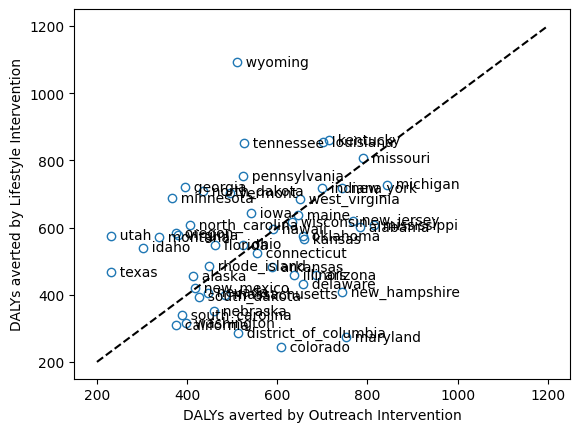

In [68]:
for i in dalys_averted_lifestyle.sort_values().index[0:]:
    plt.text(dalys_averted_outreach.loc[i], dalys_averted_lifestyle.loc[i], '  '+i.strip(), ha='left', va='center')
# plt.text(510.3, 1093.1, 'test', ha='left', va='center')
plt.plot(dalys_averted_outreach, dalys_averted_lifestyle, 'o', mec='C0', mew=1, color='none')
plt.plot([200,1200], [200, 1200], 'k--')
plt.xlabel('DALYs averted by Outreach Intervention')
plt.ylabel('DALYs averted by Lifestyle Intervention');

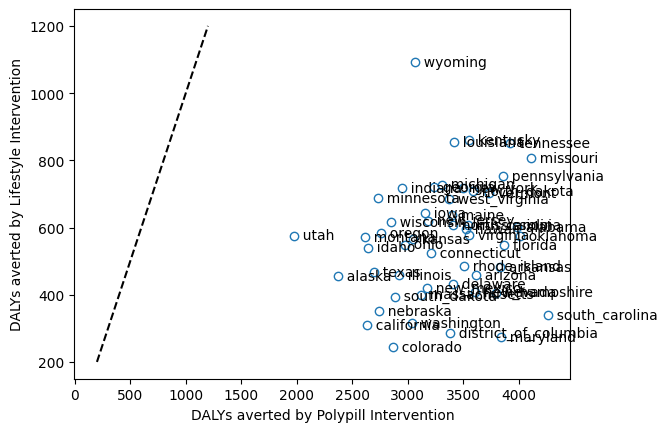

In [69]:
for i in dalys_averted_lifestyle.sort_values().index[0:]:
    plt.text(dalys_averted_polypill.loc[i], dalys_averted_lifestyle.loc[i], '  '+i.strip(), ha='left', va='center')
# plt.text(510.3, 1093.1, 'test', ha='left', va='center')
plt.plot(dalys_averted_polypill, dalys_averted_lifestyle, 'o', mec='C0', mew=1, color='none')
plt.plot([200,1200], [200, 1200], 'k--')
plt.xlabel('DALYs averted by Polypill Intervention')
plt.ylabel('DALYs averted by Lifestyle Intervention');